In [1]:
import numpy as np
from scipy.integrate import odeint
import copy as cp
import matplotlib.pylab as plt
from numpy.random import poisson
import pandas as pd

In [2]:
class Config:
    def __init__(self, params):
        params = cp.deepcopy(params)
        self.__dict__["_params"] = params
        for k, v in params.items():
            self.__dict__[k] = v

    def __getitem__(self, key):
        return self._params[key]

    def __setitem__(self, key, value):
        self.__setattr__(key, value)

    def __setattr__(self, key, value):
        self._params[key] = value
        self.__dict__[key] = value

    def clone_me(self):
        return Config(self._params)

    def update(self, kwargs):
        return Config({**self._params, **kwargs})

    def _repr_html_(self):
        return pd.Series(self._params).to_frame().T._repr_html_()

    def getkeys(self):
        return list(self._params.keys())

In [3]:
def system(pop, t, cg):
    F, A, H = pop
    dFdt = cg.rho * F + cg.tau * A - cg.alpha * F*F - cg.mu*F - cg.beta * F * H
    dAdt = cg.r * cg.p * A + cg.beta * F * H - cg.gamma * (A + H) * A - (cg.d + cg.nu) * A
    dHdt = cg.r * H + cg.r * (1 - cg.p) * A - cg.gamma * (A + H) * H - cg.d * H - cg.beta * F * H
    return [dFdt, dAdt, dHdt]

In [4]:
def sys_birth(pop, cg, V):
    F, A, H = pop/V
    bF = cg.rho * F + cg.tau * A
    bA = cg.r * cg.p * A + cg.beta * F * H
    bH = cg.r * H + cg.r * (1 - cg.p) * A
    return np.array([bF, bA, bH])

def sys_death(pop, cg, V):
    F, A, H = pop/V
    dF = cg.alpha * F*F + cg.mu*F + cg.beta * F * H
    dA = cg.gamma * (A + H) * A + (cg.d + cg.nu) * A
    dH = cg.gamma * (A + H) * H + cg.d * H + cg.beta * F * H
    return np.array([dF, dA, dH])

def tau_leap(init, birth_rate, death_rate, Tmax, dt, cg, V):
    state = [init]
    time = [0]
    tseries = np.arange(0, Tmax - 1, 1)
    for i in tseries:
        br = birth_rate(init, cg, V)
        bn = np.random.poisson(br * dt)
        dr = death_rate(init, cg, V)
        dn = np.random.poisson(dr * dt)
        init = init + bn - dn
        if any(init > 0):
            init = init * (init > 0)
            state.append(init)
            time.append(i + 1)
        else:
            break
    return dict(t = time, x = np.array(state))

In [23]:
def tau(rho, nu, cg):
    assert isinstance(rho, np.ndarray), "mutant rho has to be a numpy array"
    assert isinstance(nu, np.ndarray), "mutant nu value has to be a numpy array"
    return cg.theta - cg.v * rho**cg.h + (cg.eta * nu * (nu + cg.d)**cg.g)/cg.nu_max

def F_birth_mut(pop_F, pop_A, cg, V, rho_mut, nu_mut):
    assert isinstance(rho_mut, np.ndarray), "mutant rho has to be a numpy array"
    assert isinstance(nu_mut, np.ndarray), "mutant nu value has to be a numpy array"
    assert isinstance(pop_F, np.ndarray), "F population has to be a numpy array"
    assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    return rho_mut * pop_F/V + tau(rho_mut, nu_mut, cg) * pop_A/V

def A_birth_mut(pop_F, pop_A, pop_H, cg, V):
    assert isinstance(pop_F, np.ndarray), "F population has to be a numpy array"
    assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    return cg.r * cg.p * pop_A/V + cg.beta * (pop_F/V) * (pop_H/V)

def H_birth_mut(pop_A, pop_H, cg, V):
    assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    assert len(pop_H) == 1, "There is always one host population"
    return cg.r * pop_H/V + cg.r * (1 - cg.p) * pop_A.sum()/V


def F_death_mut(pop_F, pop_H, cg, V):
    assert isinstance(pop_F, np.ndarray), "F population has to be a numpy array"
    return cg.alpha * (pop_F/V) * (pop_F.sum())/V + cg.mu * pop_F/V + cg.beta * (pop_F/V) * (pop_H/V)


def A_death_mut(pop_F, pop_A, pop_H, cg, V, nu_mut):
    assert isinstance(nu_mut, np.ndarray), "mutant nu value has to be a numpy array"
    assert isinstance(pop_F, np.ndarray), "F population has to be a numpy array"
    assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    return cg.gamma * ((pop_A.sum() + pop_H)/V) * pop_A/V + (cg.d + nu_mut) * pop_A/V

def H_death_mut(pop_F, pop_A, pop_H, cg, V):
    assert isinstance(pop_F, np.ndarray), "F population has to be a numpy array"
    assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    assert len(pop_H) == 1, "There is always one host population"
    return cg.gamma * ((pop_A.sum() + pop_H)/V) * pop_H/V + cg.d * pop_H/V + cg.beta * (pop_F.sum()/V) * (pop_H/V)

def tau_leap_symbiosis_mutation(pop_init, Tmax, dt, cg, V, trait_init, sigma_rho, sigma_nu, mutant_rate, step):
    F_state, A_state, H_state = [], [], []
    rho_val, nu_val, tau_val = [], [], []
    time = []
    ttfull = np.arange(0, Tmax, step)
    Fs, As, Hs = pop_init[0:1], pop_init[1:2], pop_init[2:3]
    rhos, nus, taus = trait_init[0:1], trait_init[1:2], tau(trait_init[0:1], trait_init[1:2], cg)
    for i in range(Tmax):
        if any(Fs > 0) and any(Hs > 0):
            # if any population number is negative or too small, set it to zero
            Fs = np.where(Fs > 5, Fs, 0)
            As = np.where(As > 5, As, 0)
            Hs = np.where(Hs > 5, Hs, 0)
            br = A_birth_mut(Fs, As, Hs, cg, V) # rate
            dr = A_death_mut(Fs, As, Hs, cg, V, nus) # rate
            A_change = poisson(br * dt) - poisson(dr * dt) # intergers
            br = H_birth_mut(As, Hs, cg, V) # rate
            dr = H_death_mut(Fs, As, Hs, cg, V) # rate
            H_change = poisson(br * dt) - poisson(dr * dt) # intergers
            br = F_birth_mut(Fs, As, cg, V, rhos, nus) # rate
            dr = F_death_mut(Fs, Hs, cg, V) # rate
            F_change = poisson(br * dt) - poisson(dr * dt) # intergers
            # Number of mutants arise with each parent
            new_mut_arise = np.random.binomial(F_change * (F_change > 0), mutant_rate)
            ismutate = new_mut_arise > 0
            # arised mutants with corresponding parents' value
            rh = (rhos + np.random.normal(0, sigma_rho)) * ismutate
            nn = (nus + np.random.normal(0, sigma_nu)) * ismutate
            tt = tau(rh, nn, cg)
            # Only keep the trait values if they are within range
            nn_cond = (-cg.d <= nn) * (nn <= cg.nu_max)
            tt_cond = tt >= 0
            mut_cond = nn_cond * tt_cond # final conditions are the combination of conditions for both nu and rho
            rh = rh * mut_cond
            nn = nn * mut_cond
            tt = tt * mut_cond
            # Even if new mutants arise, if the traits is not within range, it does not count
            new_mut_arise = new_mut_arise * mut_cond
            # Change in F population after mutation
            F_change_after_mut = F_change - new_mut_arise
            if any(ismutate * mut_cond):
                new_mut_nb = new_mut_arise[new_mut_arise > 0]
                new_rho = rh[rh != 0]
                new_nu = nn[nn != 0] 
                new_tau = tau(new_rho, new_nu, cg)
                A_new = np.zeros(len(new_mut_nb))
            else:
                new_mut_nb, A_new = (), ()
                new_rho, new_nu, new_tau = (), (), ()          
            # Update values on next time step
            As = np.concatenate((As + A_change, A_new), axis = None)
            Hs = Hs + H_change
            Fs = np.concatenate((Fs + F_change_after_mut, new_mut_nb), axis = None)
            rhos = np.concatenate((rhos, new_rho), axis = None)
            nus = np.concatenate((nus, new_nu), axis = None)
            taus = np.concatenate((taus, new_tau), axis = None)
            # Save values with manual step
            if i in ttfull:
                A_state.append(As)
                H_state.append(Hs)
                F_state.append(Fs)
                rho_val.append(rhos)
                nu_val.append(nus)
                tau_val.append(taus)
                time.append(i)
        else:
            break
    return dict(t = time, x_F = F_state, x_A = A_state, x_H = H_state, rho = rho_val, nu = nu_val, tau = tau_val)

In [24]:
def sort_array_by_reference(data_array, reference_array, axis=0):
    """
    Sort columns of a 2D array based on a reference array.
    
    Parameters:
    -----------
    data_array : numpy.ndarray
        The 2D array to be sorted (shape should be (10, 3))
    reference_array : numpy.ndarray
        The array to use for sorting (used to determine sort indices)
    axis : int, optional
        Axis along which to sort (default is 0, sorting columns)
    
    Returns:
    --------
    numpy.ndarray
        Sorted array with columns rearranged based on reference_array
    """
    # Get the sorting indices based on the reference array
    sort_indices = np.argsort(reference_array)
    
    # Use advanced indexing to rearrange the columns
    if axis == 0:
        sorted_array = data_array[:, sort_indices]
    elif axis == 1:
        sorted_array = data_array[sort_indices, :]
    else:
        raise ValueError("axis must be 0 or 1")
    
    return sorted_array


def turn_raw_dat_to_sorted_arrays(dat):
    xF_arr, xA_arr = [], []
    r_arr, n_arr, t_arr = [], [], []
    x_F, x_A = dat["x_F"], dat["x_A"]
    rho, nu, tau = dat["rho"], dat["nu"], dat["tau"]
    assert (len(x_F[-1]) == len(x_A[-1]) == len(rho[-1]) == len(nu[-1]) == len(tau[-1]))
    tt = len(x_F[-1])
    tstep = len(dat["t"])
    for i in range(tstep):
        assert (len(x_F[i]) == len(x_A[i]) == len(rho[i]) == len(nu[i]) == len(tau[i]))
        cc = tt - len(x_F[i])
        xx = np.concatenate((x_F[i], np.zeros(cc)))
        xF_arr.append(xx)
        xx = np.concatenate((x_A[i], np.zeros(cc)))
        xA_arr.append(xx)
        xx = np.concatenate((rho[i], np.zeros(cc)))
        r_arr.append(xx)
        xx = np.concatenate((nu[i], np.zeros(cc)))
        n_arr.append(xx)
        xx = np.concatenate((tau[i], np.zeros(cc)))
    xA_rho = sort_array_by_reference(np.array(xA_arr), rho[-1])
    xA_nu = sort_array_by_reference(np.array(xA_arr), nu[-1])
    xA_tau = sort_array_by_reference(np.array(xA_arr), tau[-1])
    xF_rho = sort_array_by_reference(np.array(xF_arr), rho[-1])
    xF_nu = sort_array_by_reference(np.array(xF_arr), nu[-1])
    xF_tau = sort_array_by_reference(np.array(xF_arr), tau[-1])
    return dict(xA_rho = xA_rho, xA_nu = xA_nu, xA_tau = xA_tau,
                xF_rho = xF_rho, xF_nu = xF_nu, xF_tau = xF_tau, 
                rho_sort = np.sort(rho[-1]), nu_sort = np.sort(nu[-1]), tau_sort = np.sort(tau[-1]))

In [25]:
cg_eco = Config(dict(mu = 1.4, alpha = 1.2, gamma = 1.23, p = 0.1, beta = 2.1, 
                     r = 2.3, d = 1.3, rho = 3.6, tau = 1.1008, nu = -0.2))
cg_evo =  Config(dict(eta = 1., g = 0.312, mu = 1.4, alpha = 1.2, gamma = 1.23, p = 0.1, beta = 2.1, 
                      r = 2.3, d = 1.3, theta = 8., v = 1., h = 1.5, nu_max = 3))
init = np.array([0.1, 1., 0.2])
tseries = np.linspace(0, 10, 300)

In [26]:
d = odeint(system, init, tseries, args=(cg_eco,))

In [27]:
np.random.seed(1)
V = 100
ds = tau_leap(init * V, sys_birth, sys_death, 800, 1, cg_eco, V)

In [28]:
np.random.seed(1)
ds_test = tau_leap_symbiosis_mutation(pop_init = init * V, Tmax = 800, dt = 1, cg = cg_evo, V = V, 
                                       trait_init = np.array([3.6, -0.2]), sigma_rho = 0.2, sigma_nu = 0.2, 
                                       mutant_rate = 0, step = 1)

In [29]:
tau(np.array([3.6]), np.array([-0.2]), cg_evo)

array([1.10080137])

(0.0, 2.0)

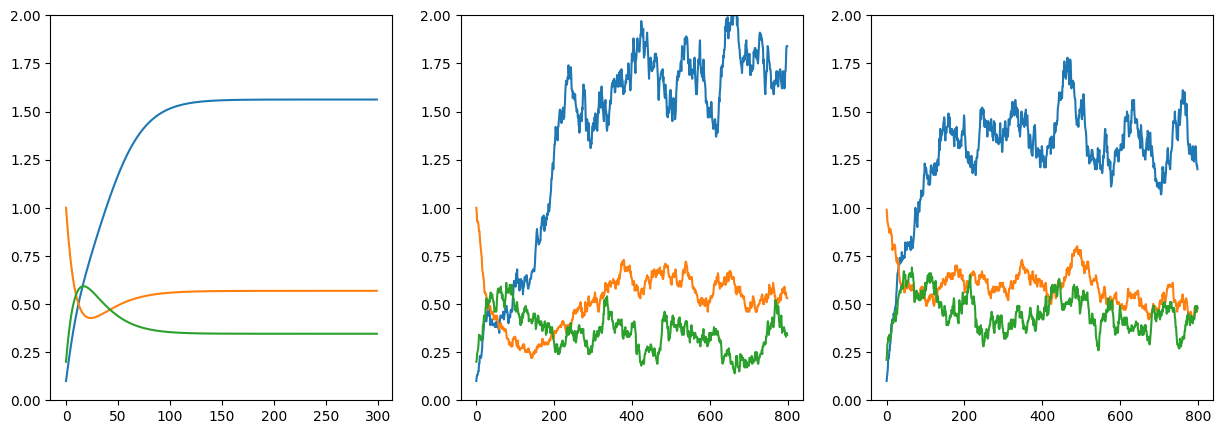

In [30]:
clist = ["C0", "C1", "C2"]
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
for i in range(3):
  axes[0].plot(d[:, i], color = clist[i])
  axes[0].set_ylim(0, 2)
  axes[1].plot(ds['x'][:, i]/V, color = clist[i])
  axes[1].set_ylim(0, 2)
axes[2].plot(ds_test["t"], np.array(ds_test["x_F"])/V,
          color = "C0")
axes[2].plot(np.array(ds_test["x_A"])/V, color = "C1")
axes[2].plot(np.array(ds_test["x_H"])/V, color = "C2")
axes[2].set_ylim(0, 2)


In [31]:
cg_evo_1 =  Config(dict(eta = 1., g = 0.312, mu = 1.4, alpha = 1.2, gamma = 1.23, p = 0.1, beta = 2.1,
                        r = 2.3, d = 1.3, theta = 8., v = 1., h = 1.5, nu_max = 3))

In [108]:
np.random.seed(1)
V = 100
dyn_stoc_1 = tau_leap_symbiosis_mutation(pop_init = init * V, Tmax = 500000, dt = 1, cg = cg_evo_1, V = V, 
                                         trait_init = np.array([2, -0.5]), sigma_rho = 0.5, sigma_nu = 0.2, 
                                         mutant_rate = 0.01, step = 50)

In [109]:
dyn_stoc_arr_1 = turn_raw_dat_to_sorted_arrays(dyn_stoc_1)

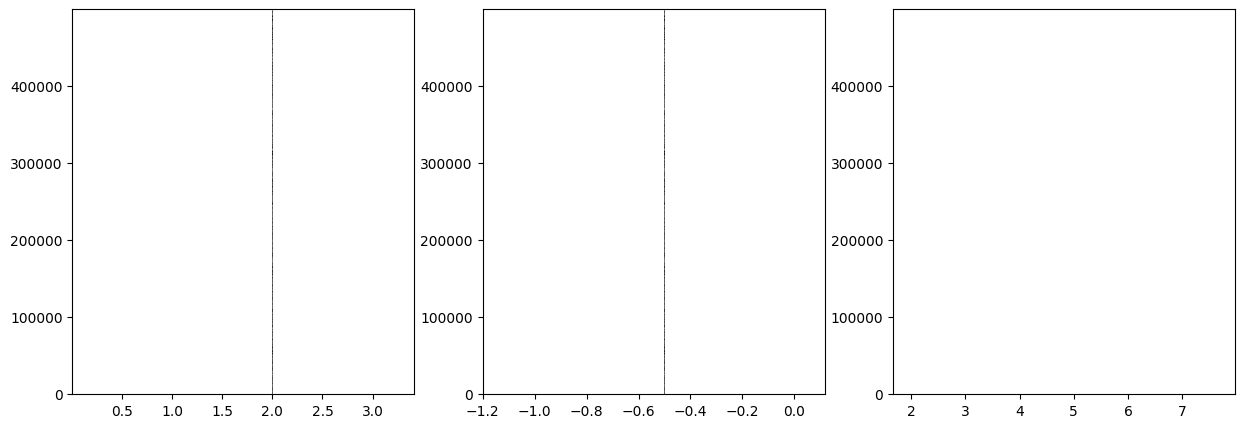

In [110]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
cc = np.where(np.sum(dyn_stoc_arr_1["xF_rho"] > 0, axis = 0) > 0)
ZZ = dyn_stoc_arr_1["xF_rho"][:, cc[0]]
XX, YY = np.meshgrid(dyn_stoc_arr_1["rho_sort"][cc[0]], dyn_stoc_1["t"])
axes[0].pcolormesh(XX, YY, ZZ/V, cmap = "Greys")
cc = np.where(np.sum(dyn_stoc_arr_1["xF_nu"] > 0, axis = 0) > 0)
ZZ = dyn_stoc_arr_1["xF_nu"][:, cc[0]]
XX, YY = np.meshgrid(dyn_stoc_arr_1["nu_sort"][cc[0]], dyn_stoc_1["t"])
axes[1].pcolormesh(XX, YY, ZZ, cmap = "Greys")
cc = np.where(np.sum(dyn_stoc_arr_1["xF_tau"] > 0, axis = 0) > 0)
ZZ = dyn_stoc_arr_1["xF_tau"][:, cc[0]]
XX, YY = np.meshgrid(dyn_stoc_arr_1["tau_sort"][cc[0]], dyn_stoc_1["t"])
axes[2].pcolormesh(XX, YY, ZZ, cmap = "Greys")